In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path

In [2]:
import numpy as np
x_test = np.load('/home/jovyan/MQTTset/x_test.npy')
x_train = np.load('/home/jovyan/MQTTset/x_train.npy')
x_val = np.load('/home/jovyan/MQTTset/x_val.npy')
y_test = np.load('/home/jovyan/MQTTset/y_test.npy')
y_train = np.load('/home/jovyan/MQTTset/y_train.npy')
y_val = np.load('/home/jovyan/MQTTset/y_val.npy')

In [3]:
# knn_org = KNeighborsClassifier()
# knn_org.fit(x_train, y_train)
# y_pred_knn = knn_org.predict(x_test)

# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# micro_f1_knn = f1_score_rep(y_test, y_pred_knn, average="micro")
# macro_f1_knn = f1_score_rep(y_test, y_pred_knn, average="macro")

# print(f'Gaussian Naive Bayes Test Accuracy: {accuracy_knn * 100:.2f}%')
# print(f'Gaussian Naive Bayes Micro F1 Score: {micro_f1_knn}')
# print(f'Gaussian Naive Bayes Macro F1 Score: {macro_f1_knn}')

In [4]:
# 定义参数
knn_params = {
    'n_neighbors': range(1, 31),  # 邻居的数量
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # 距离度量
    'p': [1, 2]  # 用于 minkowski 距离的幂参数
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Cybersecurity/Datasets/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search(x_train, y_train, param_grid):
    knn = KNeighborsClassifier()

    start = time()
    halving_knn_results = HalvingGridSearchCV(
        knn,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_knn_results.cv_results_)
    # results.to_csv(result_dir / 'halving_knn_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search(x_val, y_val, knn_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练 KNN 模型
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_knn.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_knn.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_knn.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)

     iter  rank_test_score  mean_test_score  \
359     7                1         0.931814   
360     7                1         0.931814   
356     6                3         0.925819   
357     6                3         0.925819   
358     6                3         0.925819   

                                                params  
359  {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1}  
360  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 2}  
356  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1}  
357  {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1}  
358  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 2}  
Best score for HalvingGridSearchCV is 0.932, took 19403.32 seconds
Params: {'metric': 'minkowski', 'n_neighbors': 5, 'p': 1}
Corresponding test accuracy: 71.10%
Micro F1 Score:  0.7109578003827173
Macro F1 Score:  0.5318573400026361


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

# best_knn = KNeighborsClassifier(metric='minkowski', n_neighbors=3, p=1)
# best_knn.fit(x_train, y_train)
# bestpredict = best_knn.predict(x_test)

# # 在测试集上评估
# accuracy = accuracy_score(y_test, best_knn.predict(x_test))
# micro_f1 = f1_score_rep(y_test, bestpredict, average="micro")
# macro_f1 = f1_score_rep(y_test, bestpredict, average="macro")

# # 打印结果
# # print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
# # print(f'Params: {best_params}')
# print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
# print("Micro F1 Score: ", micro_f1)
# print("Macro F1 Score: ", macro_f1)

FPR: [8.95101065e-02 2.22792420e-01 1.00902064e-05 8.41070673e-02
 9.54047411e-03 1.75387707e-02]
TPR: [0.75591818 0.89768918 0.07065217 0.57601886 0.3947529  0.84136183]
FNR: [0.24408182 0.10231082 0.92934783 0.42398114 0.6052471  0.15863817]
TNR: [0.91048989 0.77720758 0.99998991 0.91589293 0.99045953 0.98246123]
Precision: 0.6612490990080396
Accuracy: 0.7109578003827173
F1-score: 0.714970559509063
AUC: 0.8100009515471353
FPR: 0.07058315485113828
tpr: 0.589398851849094
fnr: 0.410601148150906
tnr: 0.9294168451488617


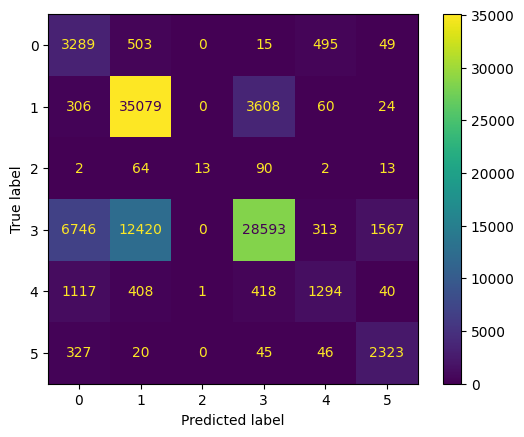

In [6]:
# best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1)
# best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_knn.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_knn.classes_)
disp.plot()
plt.show()